In [1]:
# pip install numpy xarray netCDF4 matplotlib plotly

In [2]:
# pip install "dask[complete]" -q

In [3]:
# pip install geopy ipywidgets folium -q

In [4]:
# !jupyter nbextension enable --py widgetsnbextension

In [5]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
import modules.n1_utilities as uti
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
country_to_subareas = uti.read_json_to_dict('countries.json', True)
months = uti.read_json_to_dict('months.json')
timescales = uti.read_json_to_dict('timescales.json')
area_subset_data = None
selected_country = None
selected_subarea = None
selected_month = None
selected_timescale = None

In [3]:
placeholder_country = "Select a country..."
placeholder_subarea = "Select a subarea..."
placeholder_month = "Select a month..."
placeholder_timescale = "Select a timescale..."

# First dropdown for countries
country_selector = widgets.Dropdown(
    options=[placeholder_country] + list(country_to_subareas.keys()),
    description='Country:',
    style={'description_width': 'initial'}
)

# Second dropdown for subareas, initially empty
subarea_selector = widgets.Dropdown(
    options=[],
    description='Subarea:',
    style={'description_width': 'initial'}
)

# Third dropdown for months
month_selector = widgets.Dropdown(
    options=[placeholder_month] + list(months.keys()),
    description='Select a month:',
    style={'description_width': 'initial'}
)

# Fourh dropdown for timescales
timescale_selector = widgets.Dropdown(
    options=[placeholder_timescale] + list(timescales.keys()),
    description='Select a timescale:',
    style={'description_width': 'initial'}
)

# Create dropdown widgets
country_selector = widgets.Dropdown(options=[placeholder_country] + list(country_to_subareas.keys()), description='Country:', style={'description_width': 'initial'})
subarea_selector = widgets.Dropdown(options=[], description='Subarea:', style={'description_width': 'initial'})
month_selector = widgets.Dropdown(options=[placeholder_month] + list(months.keys()), description='Select a month:', style={'description_width': 'initial'})
timescale_selector = widgets.Dropdown(options=[placeholder_timescale] + list(timescales.keys()), description='Select a timescale:', style={'description_width': 'initial'})

In [4]:
def on_value_change(change):
    """
    Responds to changes in selection widgets and updates the display accordingly. This function will be linked to the widget's observer

    This function is triggered whenever a change occurs in the selection widgets (country, subarea, month, timescale).
    It updates global variables based on the new selections, fetches geographical bounds for mapping purposes,
    and updates the displayed data and maps. If all selection conditions are met (valid country, month and timescale), 
    it triggers data processing and updates the displayed output.

    Parameters:
    change (dict): A dictionary containing details about the change event. It has keys such as 'owner'
                   (the widget that triggered the change), 'new' (the new value of the widget), and
                   'old' (the previous value of the widget).

    The function utilizes global variables to maintain state across different widget interactions. 
    These variables include:
    - area_subset_data: Data specific to the selected geographical and temporal parameters.
    - selected_country: The currently selected country.
    - selected_subarea: The currently selected subarea within the country.
    - selected_month: The currently selected month for data display.
    -  selected_timescale: The currently selected timescale for data display.

    Outputs are managed via an 'output_area' context manager that handles the display within a designated 
    Jupyter Notebook output area. This ensures that outputs such as maps and messages are properly managed and updated.
    """
    global area_subset_data, selected_country, selected_subarea, selected_month, selected_timescale

    with output_area:
        clear_output(wait=True)  # Clear the previous outputs including maps and messages
        
        # Update global variables and fetch bounds for the map
        if change['owner'] == country_selector and change['new'] != placeholder_country:
            selected_country = change['new']
            bounds = uti.get_country_bounds(selected_country)  # Fetch bounds for the selected country

        elif change['owner'] == subarea_selector and change['new'] != placeholder_subarea:
            selected_subarea = change['new']
            bounds = uti.get_country_bounds(selected_subarea)
            map_display = uti.display_map(bounds)
            display(map_display)

        elif change['owner'] == month_selector and change['new'] != placeholder_month:
            selected_month = change['new']
            
        elif change['owner'] == timescale_selector and change['new'] != placeholder_timescale:
            selected_timescale = change['new']
            
        # Update data if all selections are valid
        if country_selector.value != placeholder_country and subarea_selector.value != placeholder_subarea and month_selector.value != placeholder_month and timescale_selector.value != placeholder_timescale:
            area_subset_data = uti.update_display(
                country_selector, 
                subarea_selector, 
                month_selector, 
                timescale_selector, 
                months, 
                timescales, 
                placeholder_country, 
                placeholder_subarea, 
                placeholder_month, 
                placeholder_timescale
            )
            print(f"Data updated for: Country={selected_country}, Subarea={selected_subarea}, Month={selected_month}, Timescale={selected_timescale}")

In [5]:
# Output widgets
output_area = widgets.Output()

# Display widgets
display(country_selector, subarea_selector, month_selector, timescale_selector, output_area)


# Linking widgets to functions
country_selector.observe(
    lambda change: uti.update_subarea_selector(
        change, 
        placeholder_country, 
        placeholder_subarea, 
        subarea_selector,
        country_to_subareas
    ), 
    names='value'
)

# Attach observers to the widgets
# The generated map is just to verify that the selected area is the one of interest
country_selector.observe(on_value_change, names='value')
subarea_selector.observe(on_value_change, names='value')
month_selector.observe(on_value_change, names='value')
timescale_selector.observe(on_value_change, names='value')

Dropdown(description='Country:', options=('Select a country...', 'Brazil', 'India', 'Italy', 'Madagascar'), st…

Dropdown(description='Subarea:', options=(), style=DescriptionStyle(description_width='initial'), value=None)

Dropdown(description='Select a month:', options=('Select a month...', 'January', 'February', 'March', 'April',…

Dropdown(description='Select a timescale:', options=('Select a timescale...', '1 month', '3 months', '6 months…

Output()

In [9]:
print(selected_country)
print(selected_subarea)
print(selected_month)
print(selected_timescale)
print(area_subset_data)

Brazil
Amazonas
June
36 months
<xarray.Dataset>
Dimensions:  (lat: 234, lon: 257, time: 84)
Coordinates:
  * time     (time) datetime64[ns] 1940-06-01T06:00:00 ... 2023-06-01T06:00:00
  * lon      (lon) float64 -73.75 -73.5 -73.25 -73.0 ... -10.25 -10.0 -9.75
  * lat      (lat) float64 -56.0 -55.75 -55.5 -55.25 -55.0 ... 1.5 1.75 2.0 2.25
Data variables:
    SPEI36   (time, lat, lon) float64 dask.array<chunksize=(1, 234, 257), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPEI36
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 29 08:31:22 2024: cdo -selyear,1940 -selmon,6 /scra...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


In [12]:
index = f'SPEI{timescales[selected_timescale]}'
# print(area_subset_data[index].values)

In [13]:
area_subset_data[index] = area_subset_data[index].where(area_subset_data[index] != -9999.0) # Replace -9999.0 with NaN across the dataset

In [14]:
mean_spei = area_subset_data[index].mean(dim=['lat', 'lon'])
print(mean_spei)

<xarray.DataArray 'SPEI36' (time: 84)>
dask.array<mean_agg-aggregate, shape=(84,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1940-06-01T06:00:00 ... 2023-06-01T06:00:00


In [15]:
mean_spei_computed = mean_spei.compute()
print(mean_spei_computed)

<xarray.DataArray 'SPEI36' (time: 84)>
array([        nan,         nan,         nan, -0.84803995, -0.68192372,
       -0.501172  ,  0.08199697,  0.02864267,  0.00584526, -0.74200594,
       -0.76545847, -0.67421965, -0.25586179, -0.41344157, -0.16788842,
       -0.34292936, -0.38997434, -0.33268278, -0.39505099, -0.45891874,
       -0.81320935, -0.99911452, -1.48146306, -1.89827445, -1.83297894,
       -1.14677024, -0.88066626, -0.58555592, -0.84654431, -0.96630449,
       -0.94094595, -0.6784174 , -0.30816829,  0.02940151,  0.60459959,
        0.67137764,  0.69301407,  0.4826037 ,  0.6253808 ,  0.5453685 ,
        0.46877692,  0.41867715,  0.36471875,  0.32741584,  0.44253541,
        0.91937321,  1.13754711,  0.98314999,  0.74209955,  0.43852244,
        0.4946073 ,  0.47956336,  0.43466998,  0.49358082,  0.55614741,
        0.49071466,  0.22414868, -0.46412952,  0.00951168,  0.14711899,
       -0.047174  ,  0.32390411,  0.26965011,  0.10729508, -0.15581095,
       -0.35376578, -0.33

In [16]:
# Extract times and values for plotting
times = mean_spei_computed['time'].values
values = mean_spei_computed.values
colors = uti.assign_color_spei(values)

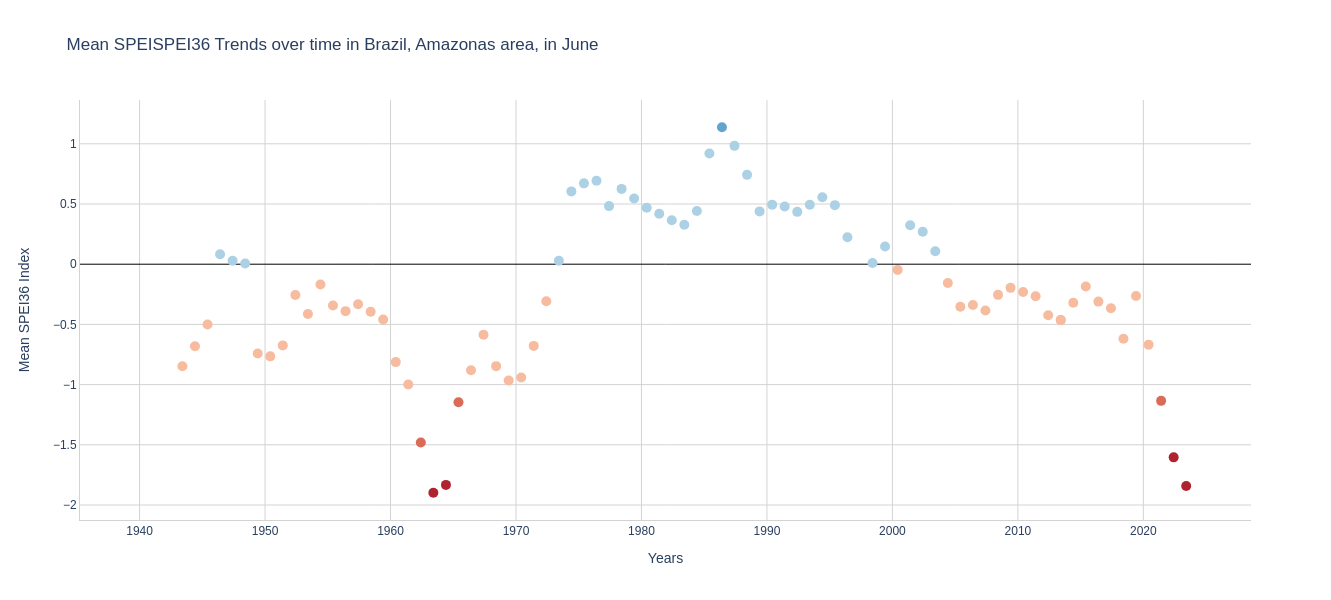

In [18]:
trace = go.Scatter(
    x=times,
    y=values,
    mode='markers',
    name='Mean SPEI12',
    marker=dict(size=10,
                color=colors,
                line=dict(width=0,
                          color='#717BFA')))

# Initialize and update the figure
fig = go.Figure([trace])
fig.update_layout(
    title=f"Mean SPEI{index} Trends over time in {selected_country}, {selected_subarea} area, in {selected_month}",
    xaxis_title='Years',
    yaxis_title=f'Mean {index} Index',
    height=600,
    plot_bgcolor='white',         # Sets the plotting area background color
    paper_bgcolor='white',  # Sets the overall background color of the chart
    xaxis=dict(
        showgrid=True,  # Enable grid (default)
        gridcolor='lightgray',  # Set grid color
        linecolor='lightgray',  # Set axis line color
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        linecolor='lightgray',
                zeroline=True,  # Ensure the zero line is visible
        zerolinewidth=1,
        zerolinecolor='black'  # Change zero line color to blue
    )
)

fig.show()

source: https://en.wikipedia.org/wiki/List_of_administrative_divisions_by_country